In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "petsmallest",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "petsmallest",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2257 files belonging to 2 classes.
Using 1806 files for training.
Found 2257 files belonging to 2 classes.
Using 451 files for validation.


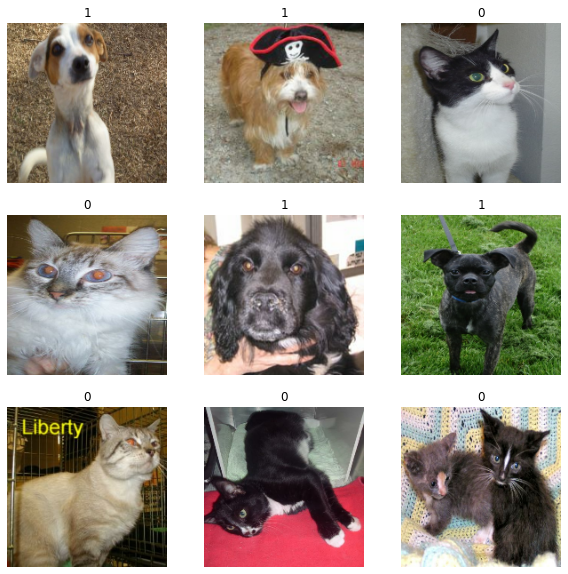

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

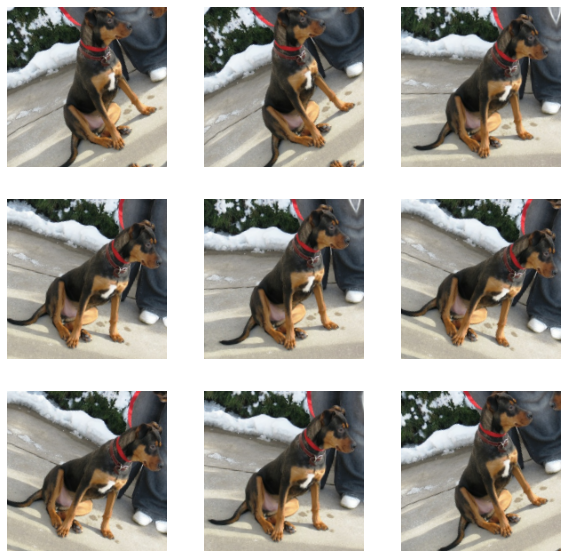

In [5]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [6]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [7]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [8]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [9]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [10]:
'''
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
   metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)
'''

'\nepochs = 5\n\ncallbacks = [\n    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),\n]\nmodel.compile(\n    optimizer=keras.optimizers.Adam(1e-3),\n    loss="binary_crossentropy",\n   metrics=["accuracy"],\n)\nmodel.fit(\n    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,\n)\n'

In [11]:
epochs = 20

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/20
57/57 [==============================] - 165s 3s/step - loss: 0.7205 - accuracy: 0.6002 - val_loss: 0.6953 - val_accuracy: 0.4856
Epoch 2/20
57/57 [==============================] - 162s 3s/step - loss: 0.6615 - accuracy: 0.6373 - val_loss: 0.7465 - val_accuracy: 0.4856
Epoch 3/20
57/57 [==============================] - 160s 3s/step - loss: 0.6092 - accuracy: 0.6755 - val_loss: 0.8709 - val_accuracy: 0.4856
Epoch 4/20
57/57 [==============================] - 160s 3s/step - loss: 0.5943 - accuracy: 0.6905 - val_loss: 0.9532 - val_accuracy: 0.4856
Epoch 5/20
57/57 [==============================] - 161s 3s/step - loss: 0.5392 - accuracy: 0.7331 - val_loss: 1.0492 - val_accuracy: 0.4856
Epoch 6/20
57/57 [==============================] - 379s 7s/step - loss: 0.5308 - accuracy: 0.7503 - val_loss: 1.2095 - val_accuracy: 0.4856
Epoch 7/20
57/57 [==============================] - 175s 3s/step - loss: 0.5177 - accuracy: 0.7514 - val_loss: 0.9607 - val_accuracy: 0.4878
Epoch 8/20
57

In [12]:
img = keras.preprocessing.image.load_img(
    "petsmallest/Cat/0.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 96.08 percent cat and 3.92 percent dog.


In [13]:
img = keras.preprocessing.image.load_img(
    "petsmallest/Dog/4.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 0.00 percent cat and 100.00 percent dog.


In [14]:
img = keras.preprocessing.image.load_img(
    "petsmallest/Dog/31.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 3.20 percent cat and 96.80 percent dog.
